The alpine1 objective function
$$
f(x, y) = \vert x \, \sin(x) + 0.1 \, x\vert + \vert y \, \sin(y) + 0.1 \, y\vert
$$
 is defined over the hypercube $[-10, 10]^2$. We consider it on a smaller domain $[-2,2]^2$

In [1]:
using Globtim
include("../src/lib_func.jl") # Include the library of functions

# Constants and Parameters
d = 8 # Initial Degree 
const n, a, b = 2, 2, 1 
const scale_factor = a / b       # Scaling factor appears in `main_computation`, maybe it should be a parameter.
const delta, alpha = .9 , 8 / 10  # Sampling parameters
const tol_l2 = 1e-1             # Define the tolerance for the L2-norm

f = alpine1; # Function to be optimized

In [2]:
while true # Potential infinite loop
    global poly_approx = MainGenerate(f, 2, d, delta, alpha, scale_factor, 0.2) # computes the approximant in Chebyshev basis
    if poly_approx.nrm < tol_l2
        println("attained the desired L2-norm: ", poly_approx.nrm)
        break
    else
        println("current L2-norm: ", poly_approx.nrm)
        println("Number of samples: ", poly_approx.N)
        global d += 1
    end
end;

current L2-norm: 0.11594165130795045
Number of samples: 17
current L2-norm: 0.11651154937797013
Number of samples: 21
attained the desired L2-norm: 0.0638003787064014


In [3]:
using DynamicPolynomials, HomotopyContinuation, ProgressLogging, DataFrames
@polyvar(x[1:n]) # Define polynomial ring 
ap = main_nd(n, d, poly_approx.coeffs, x)
# Expand the polynomial approximant to the standard monomial basis in the Lexicographic order w.r.t x. 
PolynomialApproximant = sum(Float64.(ap) .* MonomialVector(x, 0:d))
grad = differentiate.(PolynomialApproximant, x)
sys = System(grad)
println("The system is of degree:", d-1)

Check
The system is of degree:9


In [5]:
Real_sol_lstsq = HomotopyContinuation.solve(sys)
real_pts = HomotopyContinuation.real_solutions(Real_sol_lstsq; only_real=true, multiple_results=false);

In [6]:
condition(point) = -1 < point[1] < 1 && -1 < point[2] < 1
filtered_points = filter(condition, real_pts) # Filter points using the filter function
# Colllect the critical points of the approximant 
h_x = Float64[point[1] for point in filtered_points] # Initialize the x vector for critical points of approximant
h_y = Float64[point[2] for point in filtered_points] # Initialize the y vector
h_z = map(p -> f([p[1], p[2]]), zip(scale_factor * h_x, scale_factor * h_y))
df = DataFrame(x=scale_factor * h_x, y=scale_factor * h_y, z=h_z) # Create a DataFrame

Row,x,y,z
,Float64,Float64,Float64
1,-3.82124,-9.43264,3.8013
2,-9.43264,9.59453,1.67894
3,-3.82124,3.09503,3.23739
4,7.93212,-7.85285,15.7687
5,5.06558,-9.43264,5.26381
6,-5.27655,-5.27655,9.97308
7,-7.85285,-7.85285,14.1351
8,3.09503,-9.43264,1.47102
9,9.59453,-7.85285,7.72903


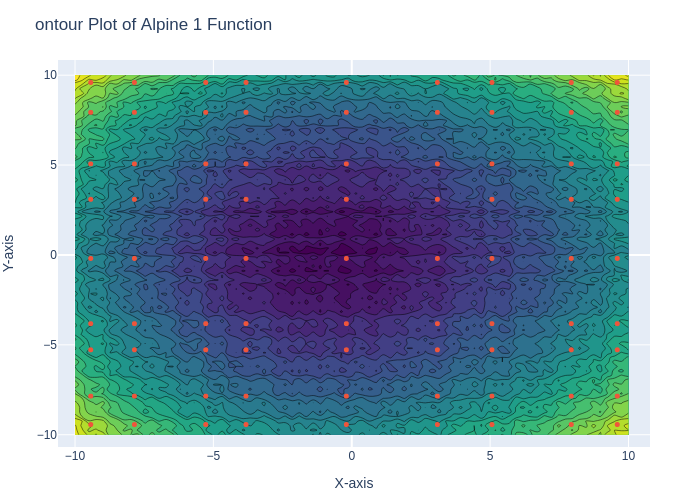

In [9]:
using PlotlyJS, Colors
# Generate the grid and evaluate the function
N = 80  # resolution of the grid
x = range(-scale_factor, scale_factor, length=N)
y = range(-scale_factor, scale_factor, length=N)
z = [tref([xi, yi]) for yi in y, xi in x]

#Scatter plot the critical points of the approximant
scatter_traces = [scatter(x=df.x, y=df.y, mode="markers", marker_size=5, name="Critical Points")]

# Create the contour plot
cp = contour(x=x, y=y, z=z, ncontours=40, colorscale="Viridis", showscale=false)

# Combine contour plot and scatter traces
all_traces = [cp; scatter_traces...]

# Customize layout to handle legend groups
layout = Layout(
    title="ontour Plot of Alpine 1 Function",
    xaxis_title="X-axis",
    yaxis_title="Y-axis",
    legend=(tracegroupgap=10, groupclick="toggleitem"),
    height=800 # Increase the height to make room for the legend 
)

# Display the combined plot with legend
display(plot(all_traces, layout))



In [ ]:
# Optimize the collected entries 
using Optim
for i in 1:nrow(df)
    println("Optimizing for point $i")
    x0 = [df.x[i], df.y[i]]
    res = Optim.optimize(f, x0, LBFGS(), Optim.Options(show_trace=true))
    minimizer = Optim.minimizer(res)
    min_value = Optim.minimum(res)
    steps = res.iterations
    converged = Optim.converged(res)
    distance = norm(x0 - minimizer)

    df.local_minima[i] = min_value
    df.distance_to_minima[i] = distance
    df.steps[i] = steps
    df.converged[i] = converged

    println(summary(res))
end
